# 라이브러리 불러오기

In [13]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')


# 랜덤 시드 설정

In [14]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [15]:
### 1. 데이터 로드 (파일 경로 수정)
# 파일 경로 설정 (상대 경로로 변경)
file_paths = {
    'train': '../data/train.csv',
    'test': '../data/test.csv',
    'interest_rate': '../data/interestRate.csv',
    'subway_info': '../data/subwayInfo.csv',
    'school_info': '../data/schoolinfo.csv',
    'park_info': '../data/parkInfo.csv'
}

# 데이터 로드
data = {name: pd.read_csv(path) for name, path in file_paths.items()}

# 금리 데이터 확인하기

In [16]:
interest_rate_data = data['interest_rate'].copy()
interest_rate_data.head()

,year_month,interest_rate
0,202405,3.56
1,202404,3.54
2,202403,3.59
3,202402,3.62
4,202401,3.66


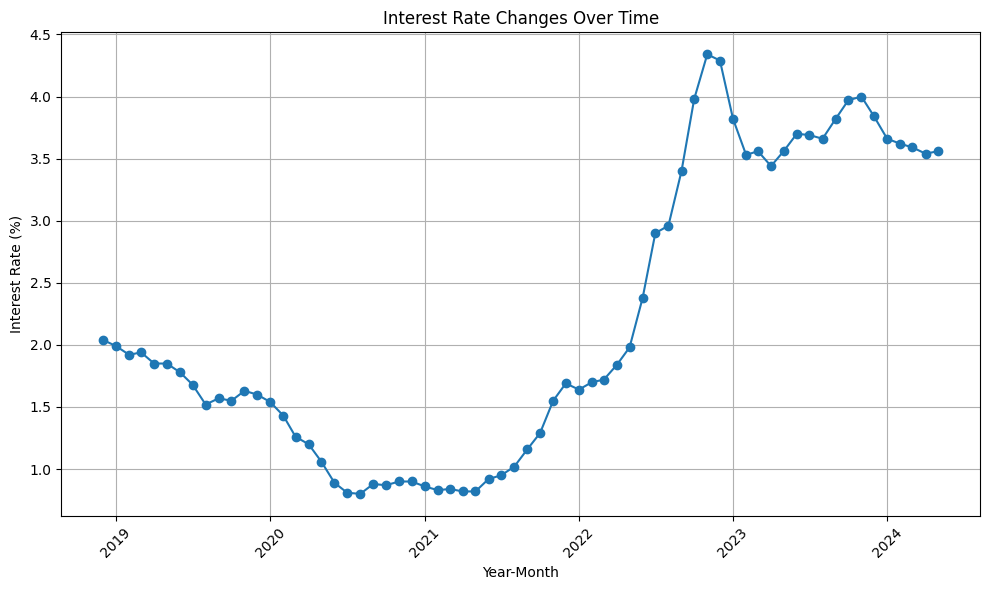

In [17]:
# Convert the year_month column to datetime format for better visualization
interest_rate_data['year_month'] = pd.to_datetime(interest_rate_data['year_month'], format='%Y%m')

# Plot the interest rate changes over time
plt.figure(figsize=(10, 6))
plt.plot(interest_rate_data['year_month'], interest_rate_data['interest_rate'], marker='o', linestyle='-')
plt.title('Interest Rate Changes Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Interest Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

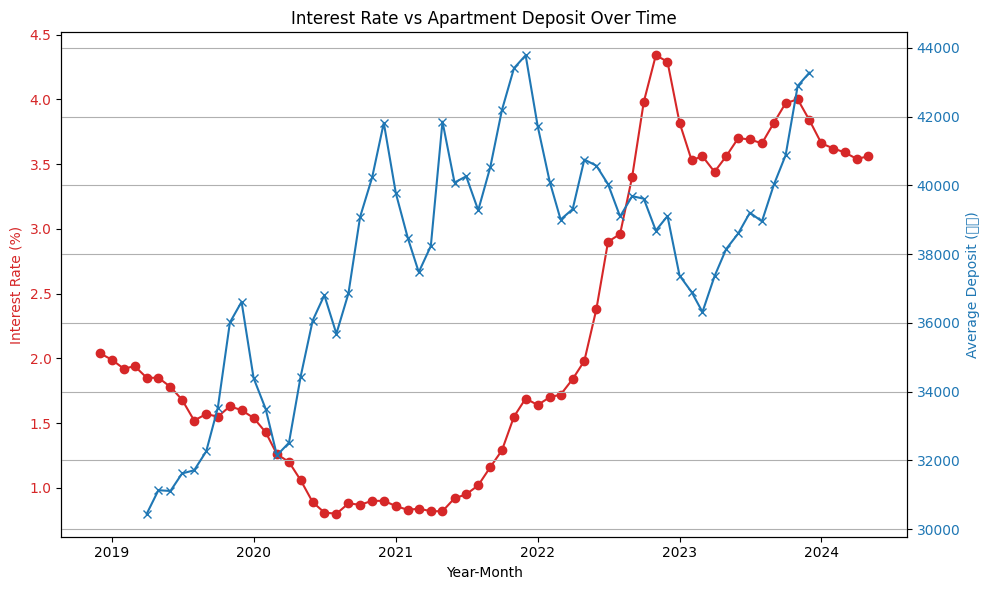

In [18]:

train_data = data['train'].copy()
# 1. 금리 데이터 전처리
# 금리 데이터를 datetime 형식으로 변환
interest_rate_data['year_month'] = pd.to_datetime(interest_rate_data['year_month'], format='%Y%m')

# 2. 전세 가격 데이터 전처리
# 계약 연도 및 계약 월을 기반으로 연월 계산
train_data['contract_year_month'] = train_data['contract_year_month'].astype(str)
train_data['contract_year_month'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')

# 연도별 평균 전세 가격 계산
year_month_deposit = train_data.groupby('contract_year_month')['deposit'].mean().reset_index()

# 3. 금리와 전세 가격 변화를 함께 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 축: 금리
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Interest Rate (%)', color='tab:red')
ax1.plot(interest_rate_data['year_month'], interest_rate_data['interest_rate'], color='tab:red', marker='o', linestyle='-', label='Interest Rate')
ax1.tick_params(axis='y', labelcolor='tab:red')

# 두 번째 축: 전세 가격
ax2 = ax1.twinx()  # 두 번째 y축 생성
ax2.set_ylabel('Average Deposit (만원)', color='tab:blue')
ax2.plot(year_month_deposit['contract_year_month'], year_month_deposit['deposit'], color='tab:blue', marker='x', linestyle='-', label='Average Deposit')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# 제목 및 기타 설정
plt.title('Interest Rate vs Apartment Deposit Over Time')
fig.tight_layout()  # 레이아웃 조정
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


- 그래프는 금리 변화와 평균 아파트 전세 가격을 비교한 것입니다.
- 2020~2021년에 금리가 급격이 낮아지면서 1.0%이하로 내려갑니다. 이 기간 동안 전세 가격은 급격하게 상승하는 추세를 보입니다.
- 2022년은 금리가 급격하게 상승하면서 전세 가격의 상승폭이 둔화되거나 하락하는 현상이 관찰됩니다.
- 2023년은 금리가 어느 정도 안정되면서 전세 가격은 완만한 상승세를 유지하고 있는 것을 볼 수 있습니다. 



- 2024년에는 금리가 3.5% 수준에서 유지되고 있으며 이로 인해, 전세 가격의 급격한 상승은 나타나지 않고 소폭 상승할 가능성이 있다고 보여집니다.
- 따라서, 2024년과 유사한 금리를 보인 2023년 데이터만을 사용하여 예측 모델을 훈련하는 것이 타당하다고 보여집니다.

In [20]:
train_data.describe()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
count,1.801228e+06,1.801228e+06,1801228,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06,1.801228e+06
mean,9.006135e+05,7.518833e+01,2021-09-25 13:32:34.418651648,1.589943e+01,1.203805e+00,1.005197e+01,2.004199e+03,3.747721e+01,1.269662e+02,1.706597e+01,3.816223e+04
min,0.000000e+00,1.032150e+01,2019-04-01 00:00:00,1.000000e+00,0.000000e+00,-4.000000e+00,1.961000e+03,3.691791e+01,1.264787e+02,-3.000000e+00,3.000000e+02
25%,4.503068e+05,5.975000e+01,2020-08-01 00:00:00,9.000000e+00,0.000000e+00,5.000000e+00,1.995000e+03,3.737976e+01,1.268422e+02,7.000000e+00,2.100000e+04
50%,9.006135e+05,7.715000e+01,2021-11-01 00:00:00,1.600000e+01,2.000000e+00,9.000000e+00,2.004000e+03,3.750227e+01,1.269976e+02,1.700000e+01,3.200000e+04
75%,1.350920e+06,8.496000e+01,2022-12-01 00:00:00,2.300000e+01,2.000000e+00,1.400000e+01,2.015000e+03,3.758205e+01,1.270888e+02,2.600000e+01,4.780000e+04
max,1.801227e+06,3.173600e+02,2023-12-01 00:00:00,3.100000e+01,2.000000e+00,6.800000e+01,2.024000e+03,3.818194e+01,1.276609e+02,6.200000e+01,1.100000e+06
std,5.199699e+05,2.552632e+01,NaN,8.625998e+00,8.852792e-01,6.973359e+00,1.115132e+01,1.625113e-01,1.701221e-01,1.112796e+01,2.610377e+04


In [21]:

## train 데이터 로드
train_data = data['train'].copy()

# 계약 연도 및 월 분리 (2023년 데이터만 사용)
train_data['contract_year'] = train_data['contract_year_month'] // 100
train_2023 = train_data[train_data['contract_year'] == 2023].copy()


# 수도권 필터링 (2023년 데이터로 한정)
seoul_region = train_2023.copy()
# 수도권 데이터 확인
print(f"2023년 수도권 데이터 개수: {len(seoul_region)}")

2023년 수도권 데이터 개수: 439653


# 지역 그룹화

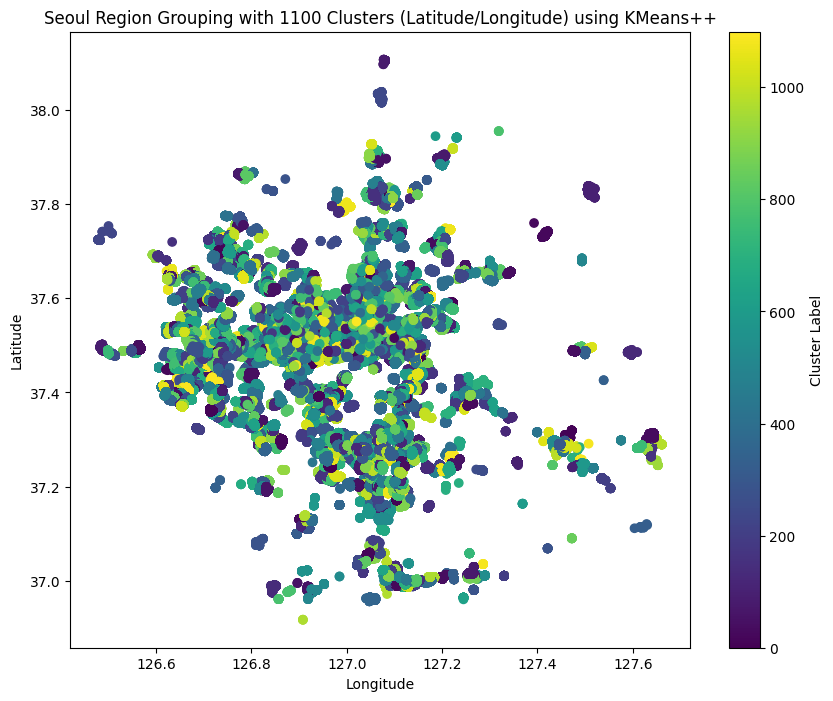

In [22]:

### 1. KMeans++로 클러스터링
# KMeans++를 적용하여 지역을 그룹화 (여기서는 1100개의 그룹으로 설정)
# 1100개는 수도권 행정동의 대략적인 수로 가정
seoul_region_1100 = seoul_region.copy()
num_clusters = 1100
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
seoul_region_1100['region_cluster'] = kmeans.fit_predict(seoul_region_1100[['latitude', 'longitude']])

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(seoul_region_1100['longitude'], seoul_region_1100['latitude'], c=seoul_region_1100['region_cluster'], cmap='viridis', marker='o')
plt.title(f'Seoul Region Grouping with {num_clusters} Clusters (Latitude/Longitude) using KMeans++')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()

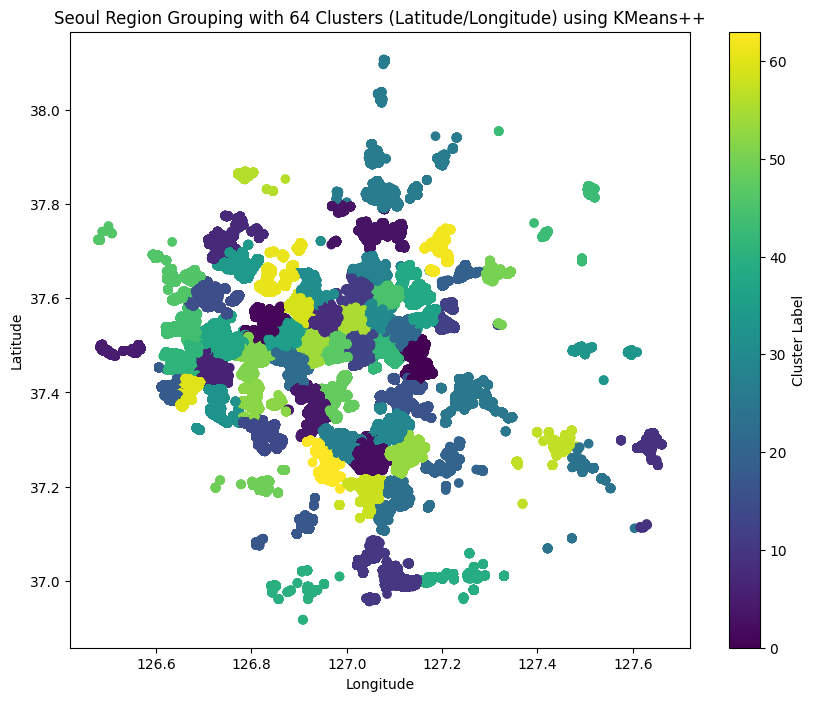

In [23]:
### 1. KMeans++로 클러스터링
# KMeans++를 적용하여 지역을 그룹화 (여기서는 64개의 그룹으로 설정)
# 64개는 수도권 도시의 대략적인 수로 가정
seoul_region_64 = seoul_region.copy()
num_clusters = 64
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
seoul_region_64['region_cluster'] = kmeans.fit_predict(seoul_region_64[['latitude', 'longitude']])

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(seoul_region_64['longitude'], seoul_region_64['latitude'], c=seoul_region_64['region_cluster'], cmap='viridis', marker='o')
plt.title(f'Seoul Region Grouping with {num_clusters} Clusters (Latitude/Longitude) using KMeans++')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()

# 수도권 아파트 단지 7000개로 가정

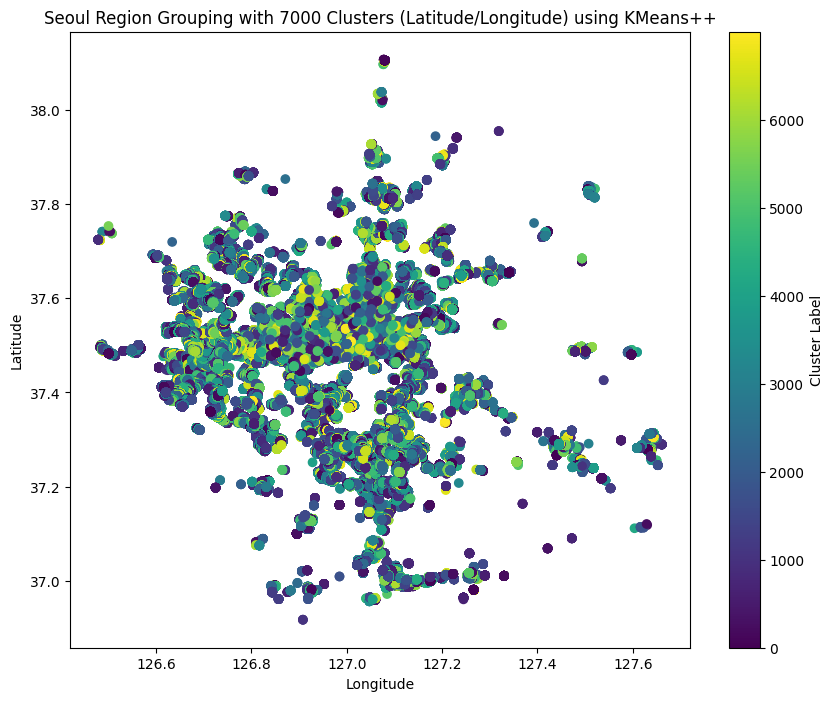

In [24]:

### 1. KMeans++로 클러스터링
# KMeans++를 적용하여 지역을 그룹화 (여기서는 7000개의 그룹으로 설정)
# 7000개는 수도권 아파트 단지의 대략적인 수로 가정
seoul_region_7000 = seoul_region.copy()
num_clusters = 7000
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
seoul_region_7000['region_cluster'] = kmeans.fit_predict(seoul_region_1100[['latitude', 'longitude']])

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(seoul_region_1100['longitude'], seoul_region_7000['latitude'], c=seoul_region_7000['region_cluster'], cmap='viridis', marker='o')
plt.title(f'Seoul Region Grouping with {num_clusters} Clusters (Latitude/Longitude) using KMeans++')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()

### 1. 1100개의 클러스터 전세 가격 분석

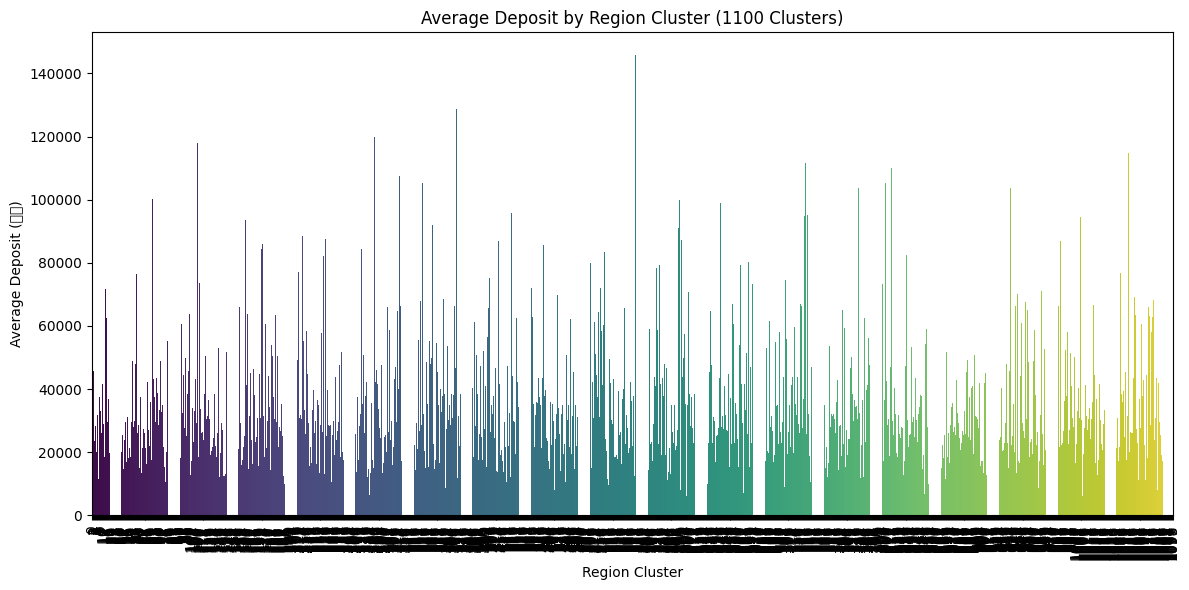

In [25]:
# 지역별 평균 전세 가격 계산 (1100개의 클러스터)
region_deposit_avg_1100 = seoul_region_1100.groupby('region_cluster')['deposit'].mean().reset_index()

# 지역별 평균 전세 가격 시각화 (1100개의 클러스터)
plt.figure(figsize=(12, 6))
sns.barplot(x='region_cluster', y='deposit', data=region_deposit_avg_1100, palette='viridis')
plt.title('Average Deposit by Region Cluster (1100 Clusters)')
plt.xlabel('Region Cluster')
plt.ylabel('Average Deposit (만원)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

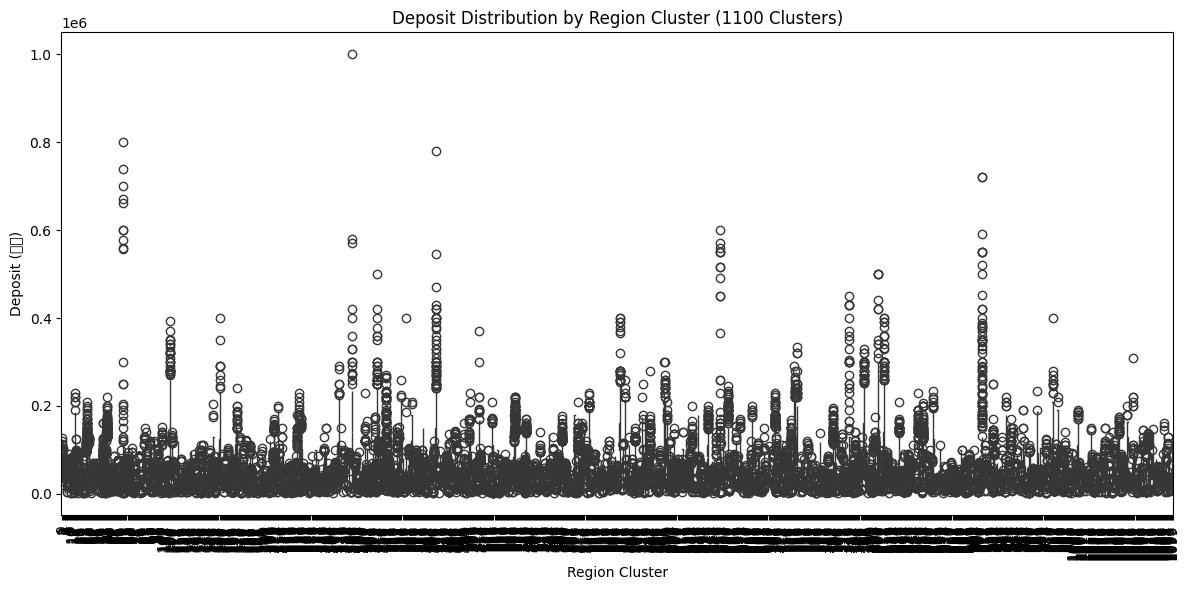

In [26]:
# 각 클러스터별 전세 가격 분포 확인 (1100개의 클러스터)
plt.figure(figsize=(12, 6))
sns.boxplot(x='region_cluster', y='deposit', data=seoul_region_1100, palette='coolwarm')
plt.title('Deposit Distribution by Region Cluster (1100 Clusters)')
plt.xlabel('Region Cluster')
plt.ylabel('Deposit (만원)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 2. 64개의 클러스터 전세 가격 분석

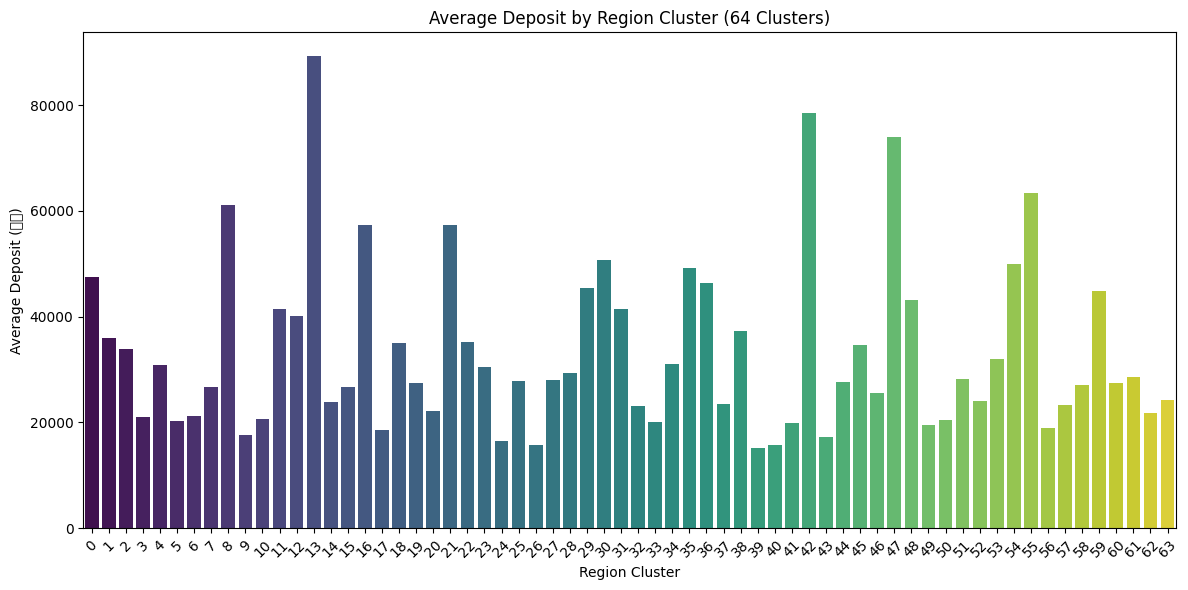

In [27]:
# 지역별 평균 전세 가격 계산 (64개의 클러스터)
region_deposit_avg_64 = seoul_region_64.groupby('region_cluster')['deposit'].mean().reset_index()

# 지역별 평균 전세 가격 시각화 (64개의 클러스터)
plt.figure(figsize=(12, 6))
sns.barplot(x='region_cluster', y='deposit', data=region_deposit_avg_64, palette='viridis')
plt.title('Average Deposit by Region Cluster (64 Clusters)')
plt.xlabel('Region Cluster')
plt.ylabel('Average Deposit (만원)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

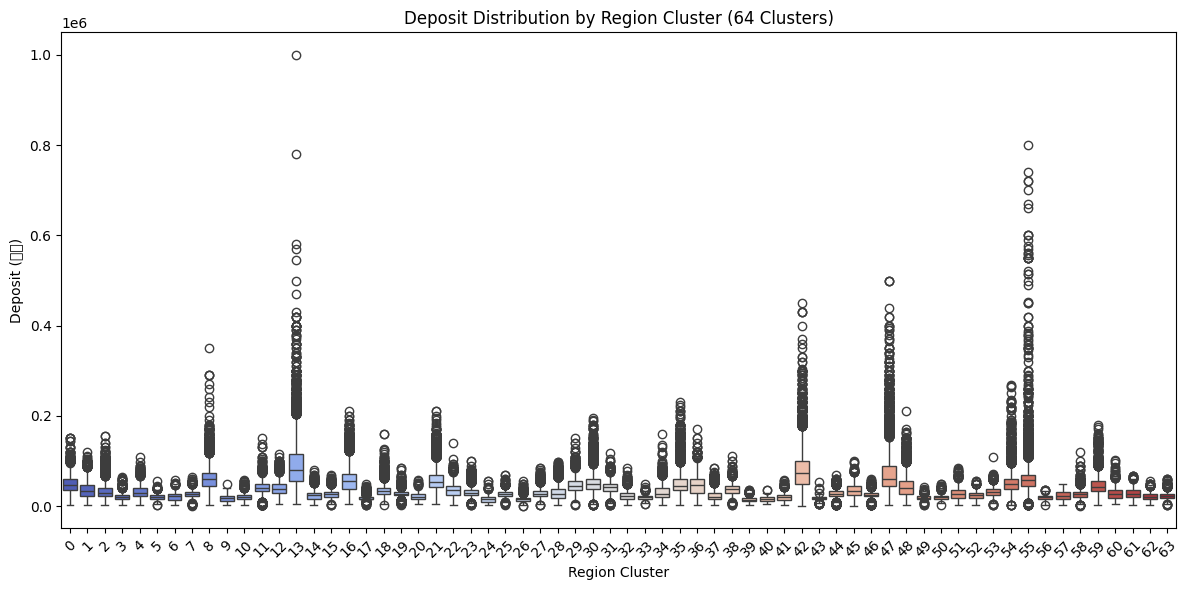

In [28]:
# 각 클러스터별 전세 가격 분포 확인 (64개의 클러스터)
plt.figure(figsize=(12, 6))
sns.boxplot(x='region_cluster', y='deposit', data=seoul_region_64, palette='coolwarm')
plt.title('Deposit Distribution by Region Cluster (64 Clusters)')
plt.xlabel('Region Cluster')
plt.ylabel('Deposit (만원)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3. 7000개의 클러스터 전세 가격 분석

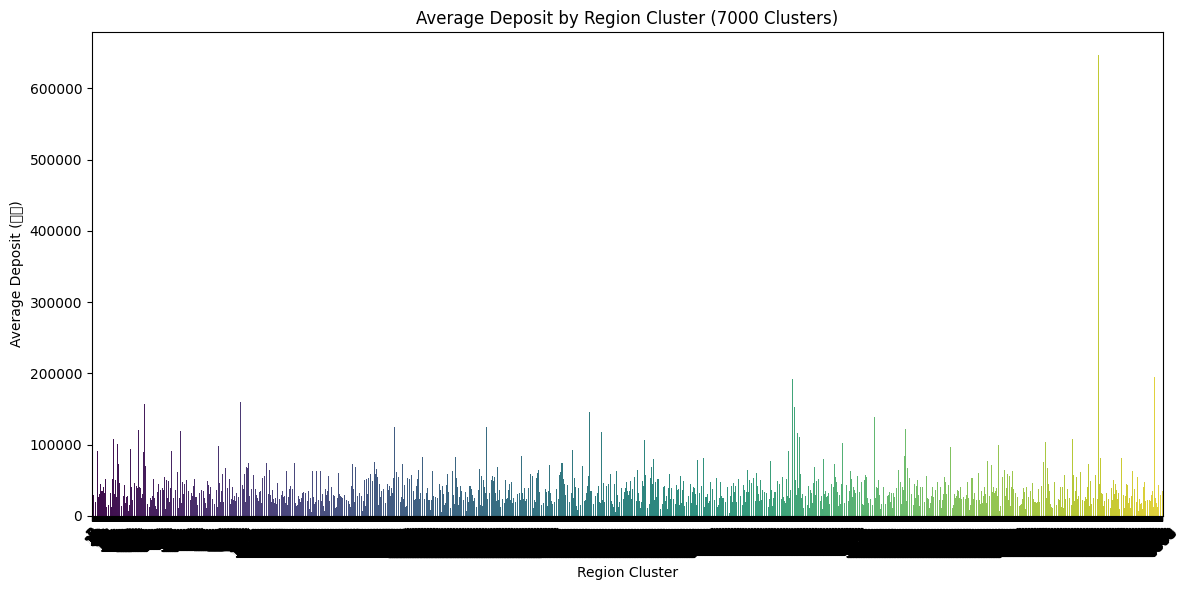

In [29]:
# 지역별 평균 전세 가격 계산 (7000개의 클러스터)
region_deposit_avg_7000 = seoul_region_7000.groupby('region_cluster')['deposit'].mean().reset_index()

# 지역별 평균 전세 가격 시각화 (64개의 클러스터)
plt.figure(figsize=(12, 6))
sns.barplot(x='region_cluster', y='deposit', data=region_deposit_avg_7000, palette='viridis')
plt.title('Average Deposit by Region Cluster (7000 Clusters)')
plt.xlabel('Region Cluster')
plt.ylabel('Average Deposit (만원)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

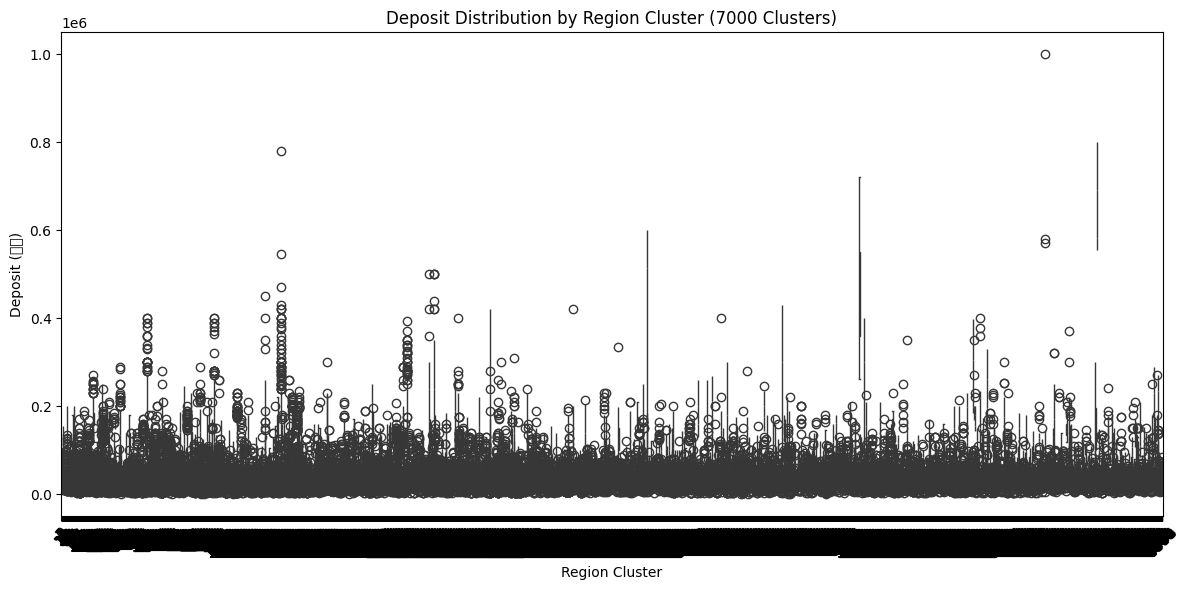

In [30]:
# 각 클러스터별 전세 가격 분포 확인 (7000개의 클러스터)
plt.figure(figsize=(12, 6))
sns.boxplot(x='region_cluster', y='deposit', data=seoul_region_7000, palette='coolwarm')
plt.title('Deposit Distribution by Region Cluster (7000 Clusters)')
plt.xlabel('Region Cluster')
plt.ylabel('Deposit (만원)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4. 분석 결과

- 1100개 클러스터는 지나치게 세분화되어 각 클러스터 간 전세 가격 차이가 뚜렷하지 않습니다.
- 반면, 64개 클러스터는 전세 가격 차이가 명확하게 드러나, 지역 특성을 잘 반영하고 있다고 보여집니다.
- 따라서, 64개 클러스터로 그룹화된 결과가 전세 가격 분석 및 예측에 더 적합하다고 판단됩니다.

In [31]:
region_deposit_avg_64.head()

,region_cluster,deposit
0,0,47545.851786
1,1,35931.676977
2,2,33896.257664
3,3,21004.590152
4,4,30820.767475


In [32]:
seoul_region_64.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,contract_year,region_cluster
547881,547881,59.8100,202303,5,0,5,1995,36.972390,127.084514,28,6500.0,2023,10
547882,547882,73.5200,202301,14,0,1,1989,36.963743,127.048600,34,7000.0,2023,10
547904,547904,39.6600,202301,13,0,5,1990,36.957089,127.047449,33,6500.0,2023,10
547925,547925,84.9342,202301,11,0,1,2016,36.965423,127.048779,7,20000.0,2023,10
547926,547926,84.9342,202301,30,0,3,2016,36.965423,127.048779,7,23000.0,2023,10


In [33]:
train_2023.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,contract_year
547881,547881,59.8100,202303,5,0,5,1995,36.972390,127.084514,28,6500.0,2023
547882,547882,73.5200,202301,14,0,1,1989,36.963743,127.048600,34,7000.0,2023
547904,547904,39.6600,202301,13,0,5,1990,36.957089,127.047449,33,6500.0,2023
547925,547925,84.9342,202301,11,0,1,2016,36.965423,127.048779,7,20000.0,2023
547926,547926,84.9342,202301,30,0,3,2016,36.965423,127.048779,7,23000.0,2023


In [34]:
# train_2023의 index 값 확인
print("train_2023의 index 값들:")
print(train_2023['index'].unique())

# seoul_region_64의 index 값 확인
print("\nseoul_region_64의 index 값들:")
print(seoul_region_64['index'].unique())

# 두 데이터프레임의 index 값이 동일한지 여부 확인
common_indices = set(train_2023['index']).intersection(set(seoul_region_64['index']))
print("\ntrain_2023와 seoul_region_64에서 공통된 index 값 개수:", len(common_indices))


train_2023의 index 값들:
[ 547881  547882  547904 ... 1801225 1801226 1801227]

seoul_region_64의 index 값들:
[ 547881  547882  547904 ... 1801225 1801226 1801227]

train_2023와 seoul_region_64에서 공통된 index 값 개수: 439653


In [35]:

# 1. 공통된 index 값으로 필터링하여 병합
common_indices = set(train_2023['index']).intersection(set(seoul_region_64['index']))

# train_2023에서 공통된 index 값만 선택
train_2023_filtered = train_2023[train_2023['index'].isin(common_indices)]

# 2. 병합
train_2023_merged = pd.merge(train_2023_filtered, seoul_region_64[['index']], on='index', how='left')

print(train_2023_merged.head())



    index  area_m2  contract_year_month  contract_day  contract_type  floor  \
0  547881  59.8100               202303             5              0      5   
1  547882  73.5200               202301            14              0      1   
2  547904  39.6600               202301            13              0      5   
3  547925  84.9342               202301            11              0      1   
4  547926  84.9342               202301            30              0      3   

   built_year   latitude   longitude  age  deposit  contract_year  
0        1995  36.972390  127.084514   28   6500.0           2023  
1        1989  36.963743  127.048600   34   7000.0           2023  
2        1990  36.957089  127.047449   33   6500.0           2023  
3        2016  36.965423  127.048779    7  20000.0           2023  
4        2016  36.965423  127.048779    7  23000.0           2023  


In [36]:
# 2. subwayInfo.csv 파일 로드 (지하철 위치 정보)
subway_info = data['subway_info'].copy()

# 3. KD-Tree를 사용하여 최근접 지하철역 찾기

# 지하철역의 위도와 경도를 배열로 변환
subway_coords = subway_info[['latitude', 'longitude']].values

# 아파트의 위도와 경도 배열로 변환
apartment_coords = train_2023_merged[['latitude', 'longitude']].values

# KD-Tree를 사용한 최근접 이웃 검색
nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(subway_coords)
distances, indices = nbrs.kneighbors(apartment_coords)

# 4. 각 아파트와 지하철역까지의 최소 거리 계산 결과를 train_2023에 추가
train_2023_merged['subway_distance'] = distances

# 5. 최종 데이터 확인
print(train_2023_merged[['latitude', 'longitude', 'subway_distance']].head())

# EDA 및 추가 분석을 위한 데이터를 준비한 후 계속 진행 가능
print(train_2023_merged.head())


    latitude   longitude  subway_distance
0  36.972390  127.084514         0.018347
1  36.963743  127.048600         0.045438
2  36.957089  127.047449         0.050533
3  36.965423  127.048779         0.044314
4  36.965423  127.048779         0.044314
    index  area_m2  contract_year_month  contract_day  contract_type  floor  \
0  547881  59.8100               202303             5              0      5   
1  547882  73.5200               202301            14              0      1   
2  547904  39.6600               202301            13              0      5   
3  547925  84.9342               202301            11              0      1   
4  547926  84.9342               202301            30              0      3   

   built_year   latitude   longitude  age  deposit  contract_year  \
0        1995  36.972390  127.084514   28   6500.0           2023   
1        1989  36.963743  127.048600   34   7000.0           2023   
2        1990  36.957089  127.047449   33   6500.0           2023 

## 이상치 탐색

In [37]:
# 데이터의 기본 통계 정보 확인
print(train_2023_merged.describe())


              index        area_m2  contract_year_month   contract_day  \
count  4.396530e+05  439653.000000        439653.000000  439653.000000   
mean   1.166863e+06      75.665768        202306.289553      15.535042   
std    4.012163e+05      24.506273             3.437602       8.531970   
min    5.478810e+05      10.321500        202301.000000       1.000000   
25%    8.195680e+05      59.820000        202303.000000       8.000000   
50%    9.294810e+05      79.740000        202306.000000      15.000000   
75%    1.551852e+06      84.960000        202309.000000      23.000000   
max    1.801227e+06     273.960000        202312.000000      31.000000   

       contract_type          floor     built_year       latitude  \
count  439653.000000  439653.000000  439653.000000  439653.000000   
mean        0.575786      10.322077    2005.391479      37.474073   
std         0.756047       7.154000      11.547404       0.164580   
min         0.000000      -2.000000    1961.000000      3

age에 minr값이 -1로 되어 있습니다. 잘못 적혀 있는 값이라고 생각할 수 있지만,
아직 준공되지 않은 아파트일 가능성을 고려하여 0으로 수정하는 방법이 합리적이라고 생각합니다.

In [38]:
# age 값이 음수인 경우 0으로 수정
train_2023_merged['age'] = train_2023_merged['age'].apply(lambda x: max(x, 0))

# 수정 후 결과 확인
print(train_2023_merged[['age']].describe())

                 age
count  439653.000000
mean       17.608739
std        11.547062
min         0.000000
25%         6.000000
50%        18.000000
75%        27.000000
max        62.000000


## 상관관계 분석

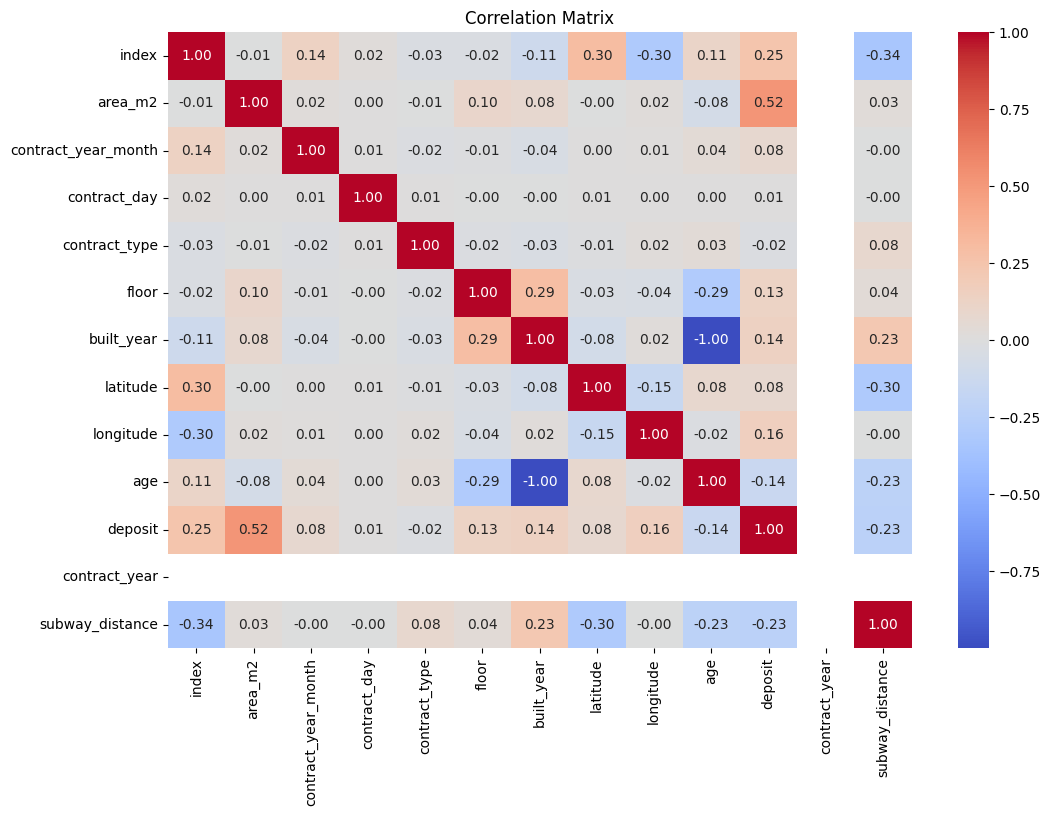

deposit                1.000000
area_m2                0.517351
index                  0.249035
longitude              0.164030
built_year             0.143289
floor                  0.129698
latitude               0.077120
contract_year_month    0.076021
contract_day           0.005636
contract_type         -0.022349
age                   -0.143304
subway_distance       -0.230421
contract_year               NaN
Name: deposit, dtype: float64


In [39]:
# 상관관계 분석 (deposit과의 상관관계 중심)
corr_matrix = train_2023_merged.corr()

# 히트맵으로 상관관계 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# deposit과 가장 상관관계가 높은 변수들 확인
deposit_corr = corr_matrix['deposit'].sort_values(ascending=False)
print(deposit_corr)

- area_m2 : 면적과 전세 가격은 가장 높은 양의 상관관계를 가집니다. 이는 면적이 넓을수록 전세 가격이 높아지는 경향을 반영합니다
- floor : 층수와 전세 가격은 양의 상관관계를 가지며, 층수가 높아질수록 조금 더 높아지는 경향이 있습니다.
- built_year : 건축 연도가 최근일수록 전세 가격이 높아집니다. 하지만 재개발 등 특수사항은 고려해 볼 사항입니다.
- subway_distance : 지하철역과의 거리가 멀수록 전세가격이 낮아지는 경향이 있습니다.